In [1]:
using Plots

gadfly();

In [14]:
function base_plot(U, V, Y)
    scatter(
        x = U, xlabel = "U", xlimits = (-1, 1.5),
        y = V, ylabel = "V", ylimits = (-1, 1.5),
        group = map((y) -> ["y = 0", "y = 1"][y+1], Y),
        markercolor = [colorant"Red" colorant"LawnGreen"],
        size = (500, 500) )
end

function contour_plot(U, V, Y, θ)
    plt = base_plot(U, V, Y)
    plot!(
        plt,
        linspace(-1, 1.5, 200),
        linspace(-1, 1.5, 200),
        (x, y) -> sigmoid(dot(map_feature(x, y), θ)),
        nlevels = 1,
        legend = false)
end
;

In [3]:
Y = convert(AbstractVector{Int}, vec(readdlm("ex5Logy.dat")))
N = length(Y)
UV = readdlm("ex5Logx.dat", ',', Float64);
U = UV[:,1]
V = UV[:,2];

[Plots.jl] Initializing backend: gadfly

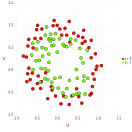

ErrorException: Install Cairo.jl to use the PNG backend. You may need to delete /home/scottc/.julia/lib/v0.4/Compose.ji afterwards.

In [4]:
base_plot(U, V, Y)

In [5]:
function map_feature(feat1::Number, feat2::Number)
    return vec(map_feature([feat1], [feat2]))
end

function map_feature(feat1::AbstractVector, feat2::AbstractVector)
    degree = 6
    
    out = ones(size(feat1))
    
    for i = 1:degree
        for j = 0:i
            out = [out (feat1.^(i-j)) .* (feat2.^j)]
        end
    end
    
    return out
end;

In [6]:
X = map_feature(U, V);
P = size(X, 2)

28

In [7]:
function sigmoid(a)
    1 ./ (1 .+ exp(-a))
end

function h(xₙ::AbstractVector, θ::AbstractVector)
    sigmoid(dot(xₙ, θ))
end

function h(X::AbstractMatrix, θ::AbstractVector)
    sigmoid(X * θ)
end

function cost(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    hₓ = h(X, θ)
    
    J = sum(-Y .* log(hₓ) - (1 .- Y) .* log(1 - hₓ)) / N
    
    reg = λ/(2N) * dot(θ, θ)
    
    return J + reg
end

function gradient(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    hₓ = h(X, θ)
    
    ∇ = vec(sum((hₓ .- Y) .* X, 1)) ./ N
    
    reg = λ .* θ ./ N
    reg[1] = 0
    
    return ∇ .+ reg
end

function Hessian(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    N = length(Y)
    P = length(θ)
    hₓ = h(X, θ)
    
    c = hₓ .* (1 - hₓ)
    
    H = zeros(Float64, (P, P))
    
    for i in 1:length(c)
        H .+= c[i] .* X[i, :]' * X[i, :]
    end
    
    H ./= N
    
    reg = λ/N .* eye(P)
    reg[1, 1] = 0
    
    return H .+ reg
end

function Newtons(X::AbstractMatrix, Y::AbstractVector, θ::AbstractVector, λ::Number)
    I = 1000
    
    J = Array{Float64}(I)
    J[1] = cost(X, Y, θ, λ)
    
    for i in 2:I
        ∇J = gradient(X, Y, θ, λ)
        H = Hessian(X, Y, θ, λ)
        
        δ = H \ ∇J
        
        θ -= δ
        
        J[i] = cost(X, Y, θ, λ)
        
        if norm(J[i] - J[i-1]) < 1e-9
            return (θ, J[1:i])
        end
    end

    error("Failed to converge after $I iterations")
end

;

Converged after 7 iterations


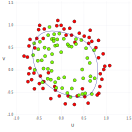

norm(θ) = 10.88231256360369


ErrorException: Install Cairo.jl to use the PNG backend. You may need to delete /home/scottc/.julia/lib/v0.4/Compose.ji afterwards.

In [21]:
λ = 0.1

(θ, J) = Newtons(X, Y, zeros((P,)), λ)

println("Converged after $(length(J)) iterations")
println("norm(θ) = $(norm(θ))")

contour_plot(U, V, Y, θ)

In [ ]:
plot(J)